In [1]:
from simulate_game import simulate_game
from competitive_sudoku.sudoku import load_sudoku

import importlib
import sys
import io
import os
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from tqdm import tqdm

In [ ]:
# Winner 0 if it was a draw, 1 if player 1 won, 2 if player 2 won
# Reason:
# "regular" if it was played till the end
# "taboo" if a taboo move was played
# "invalid" if invalid move was played
# "illegal" if illegal move was played
# "no move" if no move was supplied


def run_simulation(first_player: str, second_player: str, board_name: str, time: float) -> set:
    player1 = importlib.import_module(first_player + '.sudokuai').SudokuAI()
    player2 = importlib.import_module(second_player + '.sudokuai').SudokuAI()
    player1.player_number = 1
    player2.player_number = 2
    
    # We do not check for specific ai, just give it to all of them
    player1.solve_sudoku_path = 'bin\\solve_sudoku.exe'
    player2.solve_sudoku_path = 'bin\\solve_sudoku.exe'
    
    board = load_sudoku(board_name)
    
    # Note for future, we do not clean up files
    
    old_stdout = sys.stdout
    sys.stdout = buffer = io.StringIO()
    
    simulate_game(board, player1, player2, solve_sudoku_path='bin\\solve_sudoku.exe', calculation_time=time)
    
    sys.stdout = old_stdout
    result = buffer.getvalue()
    
    last_line = result.splitlines()[-1]
    splitted_line = last_line.split(".")
    
    if len(splitted_line) == 2:
        winner = {"The game ends in a draw": 0, "Player 1 wins the game":1, 
                  "Player 2 wins the game":2}[splitted_line[0]]
        reason = "regular"
    
    else:
        winner = {" The game ends in a draw": 0, " Player 1 wins the game":1, 
                  " Player 2 wins the game":2}[splitted_line[1]]
        reason = {"taboo move": "taboo", "valid move": "invalid", "legal move": "illegal", 
                  "s supplied": "no move"}[splitted_line[0][-10:]]
    
    return winner, reason

In [ ]:
opponents = ["random_player", "greedy_player"]
boards = os.listdir("boards")
times = [0.1, 0.5, 1, 5]
starting = [True, False]

In [ ]:
testing = "team41_A1"
df = pd.DataFrame(columns = ["opponent", "board", "time", "starting", "result", "reason"])
counter = 0

for setup in tqdm(list(itertools.product(opponents, boards, times, starting))):
    if setup[3]:
        winner, reason = run_simulation(testing, setup[0], f'boards//{setup[1]}', setup[2])
        result = {0: 0, 1:1, 2:-1}[winner]
    
    else:
        winner, reason = run_simulation(setup[0], testing, f'boards//{setup[1]}', setup[2])
        result = {0: 0, 1:-1, 2:1}[winner]
    
    new_row = pd.DataFrame({"opponent":setup[0][:-7], "board": setup[1][:-4], "time": setup[2], 
                            "starting": setup[3], "result": 1, "reason": "regular"}, index=[0])
    
    df = pd.concat([df, new_row]).reset_index(drop = True)
    
    counter += 1
    if counter % 10 == 0:
        df.to_csv(f'testing results//{testing}.csv', index = False)

df.to_csv(f'testing results//{testing}.csv', index = False)

In [ ]:
result = run_simulation("team41_A2_testing_Ricc", "greedy_player", "boards\\easy-3x3.txt", 0.5)
print(result)

In [ ]:
result = run_simulation("random_player", "greedy_player","boards\\easy-3x3.txt", 1)
print(result)

In [2]:
df = pd.read_csv("testing results//team41_A1.csv")

In [3]:
wi = round(len(df[df["result"]==1])/len(df),2)
print(f"Overall Winrate: {wi}")

opx = []
opy = []
for op in ["random", "greedy"]:
    opx.append(op)
    opy.append(round(len(df[(df["opponent"]==op) & (df["result"]==1)])/len(df[df["opponent"]==op]),2))
    
stx = []
sty = []
for st in [True, False]:
    stx.append({False: "second", True: "starting"}[st])
    sty.append(round(len(df[(df["starting"]==st) & (df["result"]==1)])/len(df[df["starting"]==st]),2))
    
tix = []
tiy = []
for ti in [0.1, 0.5, 1, 5]:
    tix.append(str(ti))
    tiy.append(round(len(df[(df["time"]==ti) & (df["result"]==1)])/len(df[df["time"]==ti]),2))

six = []
siy = []
for si in ["2x2", "2x3", "3x3", "3x4", "4x4"]:
    six.append(si)
    siy.append(round(len(df[(df["board"].str.contains(si)) & (df["result"]==1)])/len(df[df["board"].str.contains(si)]),2))

Overall Winrate: 0.45


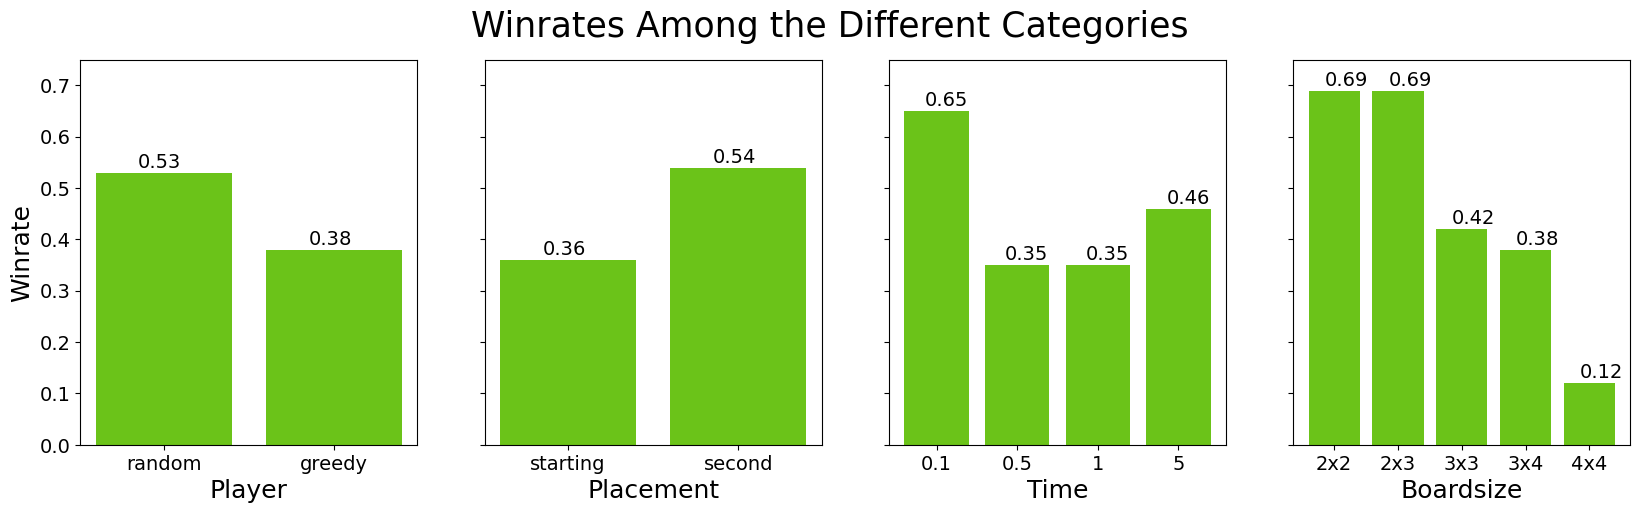

In [28]:
fig, axs = plt.subplots(1, 4, sharey = True, figsize=(20,5))
fig.suptitle("Winrates Among the Different Categories", fontsize=25)

axs[0].bar(opx, opy, color = "#6BC319")
axs[0].set_xlabel("Player", fontsize=18)
axs[0].set_ylabel("Winrate", fontsize=18)
axs[0].tick_params(axis="both", labelsize=14)
axs[0].set_ylim(top=0.75)

axs[1].bar(stx, sty, color = "#6BC319")
axs[1].set_xlabel("Placement", fontsize=18)
axs[1].tick_params(axis="both", labelsize=14)

axs[2].bar(tix, tiy, color = "#6BC319")
axs[2].set_xlabel("Time", fontsize=18)
axs[2].tick_params(axis="both", labelsize=14)

axs[3].bar(six, siy, color = "#6BC319")
axs[3].set_xlabel("Boardsize", fontsize=18)
axs[3].tick_params(axis="both", labelsize=14)

for i in range(4):
    for p in axs[i].patches:
        axs[i].annotate(str(p.get_height()), (p.get_x() + 0.25, p.get_height() + 0.01), fontsize=14)
        
text = False

if (text):
    # Define bbox style
    box_style=dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # Text inside a box
    plt.text(-18.7, 0.65, "Overall winrate: 0.91",{'color':'black','weight':'heavy','size':13},bbox=box_style)
    plt.text(-12.2, 0.65, "Overall winrate: 0.90",{'color':'black','weight':'heavy','size':13},bbox=box_style)   
    plt.text(-5.4, 0.65, "Overall winrate: 1.81",{'color':'black','weight':'heavy','size':13},bbox=box_style)   
    plt.text(1.7, 0.6, "Overall winrate: \n 2.30",{'color':'black','weight':'heavy','size':13},bbox=box_style)   

plt.savefig("testing results//A1_test_result.png");